In [7]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
from matplotlib.pyplot import figure
import time
import random
import pandas as pd

from scipy import signal
from scipy import misc
from scipy.spatial import distance
from skimage.measure import find_contours, approximate_polygon, subdivide_polygon

from ipywidgets import Image
from ipycanvas import Canvas

In [8]:
def random_color():
    levels = range(32,256,16)
    return tuple(random.choice(levels) for _ in range(3))

In [9]:
img = []
img4 = []
img_orig = []

### Load image

##### Insert white border around image

In [10]:
img = cv2.imread("map.png", cv2.IMREAD_GRAYSCALE);
backtorgb = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB);
img = backtorgb.dot([0.33,0.33,0.33])

(my,mx)=img.shape
#img[0,:]=255
#img[:,0]=255
#img[my-1,:]=255
#img[:,mx-1]=255

img_orig = img.copy()

image_data = np.stack((backtorgb[:,:,0],backtorgb[:,:,1],backtorgb[:,:,2]), axis=2)

In [11]:
def showimage(img):
    figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
    plt.imshow(img)
    plt.show()


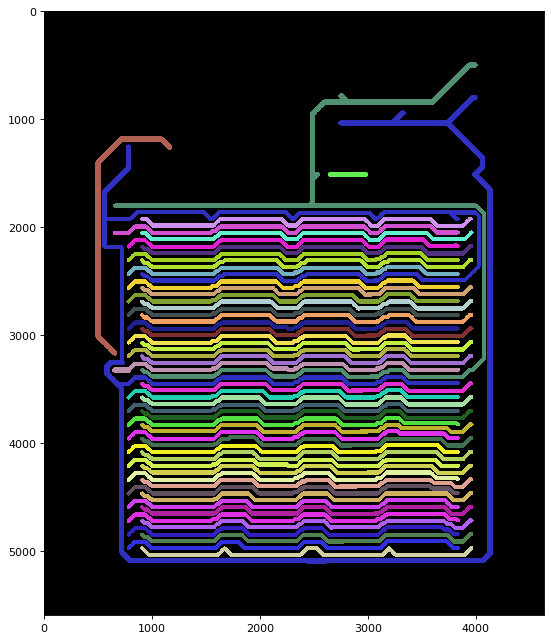

In [12]:
r = backtorgb[:,:,0].copy()
g = backtorgb[:,:,0].copy()
b = backtorgb[:,:,0].copy()

for y in range(my):
    for x in range(mx):
        if r[y,x]==255:
            fr = random_color()
            mask = np.zeros((my+2, mx+2), np.uint8)
            cv2.floodFill(r, mask, (x,y),fr[0])
            mask = np.zeros((my+2, mx+2), np.uint8)
            cv2.floodFill(g, mask, (x,y),fr[1])
            mask = np.zeros((my+2, mx+2), np.uint8)
            cv2.floodFill(b, mask, (x,y),fr[2])
            
image_data = np.stack((r,g,b),axis=2)
showimage(image_data)

### Process Image to find middle point between tracks

##### Difference between subsequent dilations

In [13]:
canvas2 = Canvas(width=640, height=400)
clas = 0

rr = r.copy()
gg = g.copy()
bb = b.copy()

canvas2

Canvas(height=400, width=640)

In [14]:
clas = True
while clas:
    
    clas=False
    for y in range(1,my-1):
        for x in range(1,mx-1):
            if r[y,x]==0: ## if pixel is a background colour
                nsr = [r[y-1,x-1],r[y-1,x],r[y-1,x+1],r[y,x-1],r[y,x+1],r[y+1,x-1],r[y+1,x],r[y+1,x+1]]
                nsg = [g[y-1,x-1],g[y-1,x],g[y-1,x+1],g[y,x-1],g[y,x+1],g[y+1,x-1],g[y+1,x],g[y+1,x+1]]
                nsb = [b[y-1,x-1],b[y-1,x],b[y-1,x+1],b[y,x-1],b[y,x+1],b[y+1,x-1],b[y+1,x],b[y+1,x+1]]
                
                nsr = list(filter(lambda a: a != 0, nsr))  ## get surrounding non-background pixes
                nsg = list(filter(lambda a: a != 0, nsg))
                nsb = list(filter(lambda a: a != 0, nsb))
                
                if nsr != []: ## if there are neighborouhing pixels
                    clas=True
                    rr[y,x] = max(set(nsr), key = nsr.count) ## then put centre pixel same colour as 
                    gg[y,x] = max(set(nsg), key = nsg.count) ## majority of colour of neighborouring pixels
                    bb[y,x] = max(set(nsb), key = nsb.count)
            else:
                rr[y,x]=r[y,x]  ## if co-ord is non background then copy pixel colour
                gg[y,x]=g[y,x]
                bb[y,x]=b[y,x]
    
    r=rr.copy()
    g=gg.copy()
    b=bb.copy()

    image_data = np.stack((r,g,b),axis=2)
    canvas2.put_image_data(image_data,0,0)
    canvas2
    print(".",end="")

for y in range(1,my-1):
    x=0
    nsr = [r[y-1,x],r[y-1,x+1],r[y,x+1],r[y+1,x],r[y+1,x+1]]
    nsg = [g[y-1,x],g[y-1,x+1],g[y,x+1],g[y+1,x],g[y+1,x+1]]
    nsb = [b[y-1,x],b[y-1,x+1],b[y,x+1],b[y+1,x],b[y+1,x+1]]

    nsr = list(filter(lambda a: a != 0, nsr))  ## get surrounding non-background pixes
    nsg = list(filter(lambda a: a != 0, nsg))
    nsb = list(filter(lambda a: a != 0, nsb))

    if nsr != []: ## if there are neighborouhing pixels
        rr[y,x] = max(set(nsr), key = nsr.count) ## then put centre pixel same colour as 
        gg[y,x] = max(set(nsg), key = nsg.count) ## majority of colour of neighborouring pixels
        bb[y,x] = max(set(nsb), key = nsb.count)
        
    
    x=mx-1
    nsr = [r[y-1,x-1],r[y-1,x],r[y,x-1],r[y+1,x-1],r[y+1,x]]
    nsg = [g[y-1,x-1],g[y-1,x],g[y,x-1],g[y+1,x-1],g[y+1,x]]
    nsb = [b[y-1,x-1],b[y-1,x],b[y,x-1],b[y+1,x-1],b[y+1,x]]

    nsr = list(filter(lambda a: a != 0, nsr))  ## get surrounding non-background pixes
    nsg = list(filter(lambda a: a != 0, nsg))
    nsb = list(filter(lambda a: a != 0, nsb))

    if nsr != []: ## if there are neighborouhing pixels
        rr[y,x] = max(set(nsr), key = nsr.count) ## then put centre pixel same colour as 
        gg[y,x] = max(set(nsg), key = nsg.count) ## majority of colour of neighborouring pixels
        bb[y,x] = max(set(nsb), key = nsb.count)

for x in range(1,mx-1):
    y=0
    nsr = [r[y,x-1],r[y,x+1],r[y+1,x-1],r[y+1,x],r[y+1,x+1]]
    nsg = [g[y,x-1],g[y,x+1],g[y+1,x-1],g[y+1,x],g[y+1,x+1]]
    nsb = [b[y,x-1],b[y,x+1],b[y+1,x-1],b[y+1,x],b[y+1,x+1]]

    nsr = list(filter(lambda a: a != 0, nsr))  ## get surrounding non-background pixes
    nsg = list(filter(lambda a: a != 0, nsg))
    nsb = list(filter(lambda a: a != 0, nsb))

    if nsr != []: ## if there are neighborouhing pixels
        rr[y,x] = max(set(nsr), key = nsr.count) ## then put centre pixel same colour as 
        gg[y,x] = max(set(nsg), key = nsg.count) ## majority of colour of neighborouring pixels
        bb[y,x] = max(set(nsb), key = nsb.count)
        
    
    y=my-1
    nsr = [r[y-1,x-1],r[y-1,x],r[y-1,x+1],r[y,x-1]]
    nsg = [g[y-1,x-1],g[y-1,x],g[y-1,x+1],g[y,x-1]]
    nsb = [b[y-1,x-1],b[y-1,x],b[y-1,x+1],b[y,x-1]]

    nsr = list(filter(lambda a: a != 0, nsr))  ## get surrounding non-background pixes
    nsg = list(filter(lambda a: a != 0, nsg))
    nsb = list(filter(lambda a: a != 0, nsb))

    if nsr != []: ## if there are neighborouhing pixels
        rr[y,x] = max(set(nsr), key = nsr.count) ## then put centre pixel same colour as 
        gg[y,x] = max(set(nsg), key = nsg.count) ## majority of colour of neighborouring pixels
        bb[y,x] = max(set(nsb), key = nsb.count)
        
    

.

KeyboardInterrupt: 

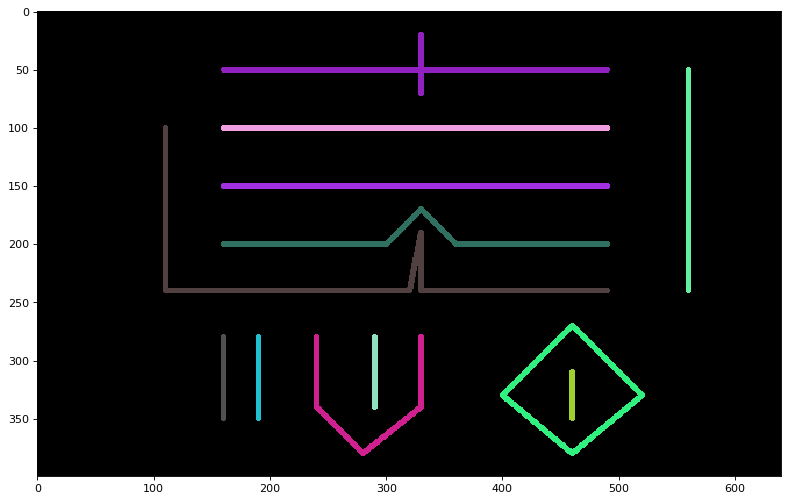

In [8]:
showimage(image_data)

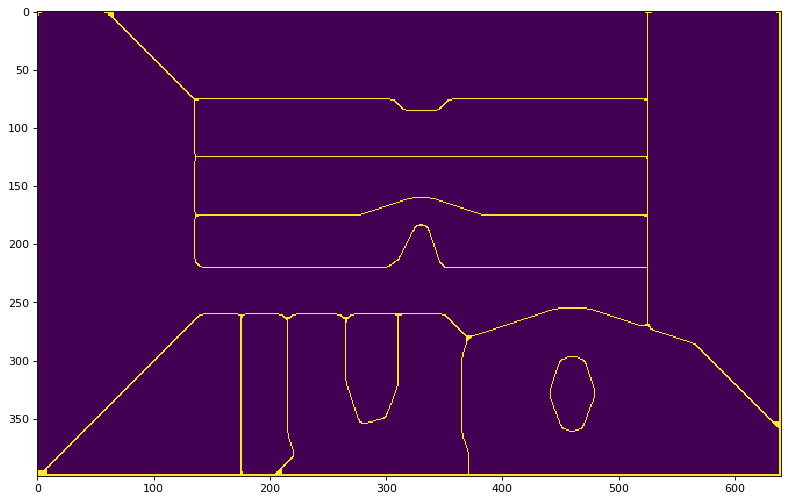

In [9]:
#cv2.imwrite("bordergrow.png",image_data)
image_data=cv2.imread("bordergrow.png")
edges = cv2.Canny(image_data,50,150,apertureSize = 7)
kernel = np.ones((5,5),np.uint8)
edged = cv2.dilate(edges,kernel,1)
edged = cv2.erode(edged,kernel,1)
showimage(edged)

In [10]:
contours = find_contours(edged, 240,fully_connected='high',positive_orientation='low')

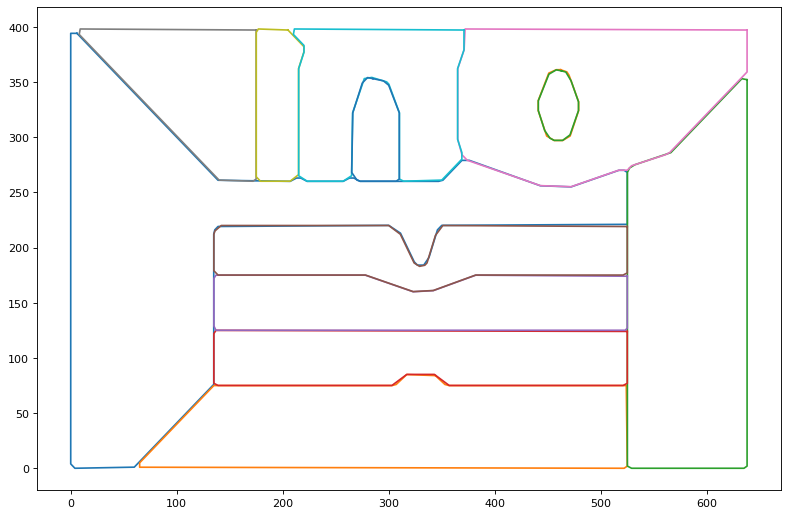

In [11]:
figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k');
lines = []
for n, contour in enumerate(contours):
    newcontour = approximate_polygon(contour,1)
    
    c = np.expand_dims(newcontour.astype(np.float32), 1)
    c = cv2.UMat(c)
    area = int(cv2.contourArea(c))
    
    lencnt = len(newcontour)    
    [fy,fx] = newcontour[0]
    for i in range(1,lencnt):
        [y,x] = newcontour[i]
        
        length = ((x-fx)**2+(y-fy)**2)**0.5

        #lines.append([int(x),int(y),int(fx),int(fy)])
        if fx!=x:
            m = (fy-y)/(fx-x)
            angle=np.arctan(m)
            cut = y - m*x
        else:
            angle=np.pi/2
            cut = x
        
        lines.append([x,y,fx,fy,angle,cut,length])
        (fx,fy)=(x,y)
    
    plt.plot(newcontour[:,1],newcontour[:,0])
plt.show()

In [12]:
lines_left = lines.copy()
for i in lines:
    [ax1,ay1,ax2,ay2,ag1,ac1,ll1] = i
    lines_left.remove(i)
    for j in lines_left:
        [bx1,by1,bx2,by2,bg1,bc1,ll2] = j
        
        if abs(ag1-bg1)<0.2:
            do_remove=False
            
            if abs(ax1-bx1)<min(ll1,ll2)/2 and abs(ay1-by1)<min(ll1,ll2)/2:
                if abs(ax2-bx2)<10 and abs(ay2-by2)<10:
                    do_remove=True
                
            if abs(ax1-bx2)<10 and abs(ay1-by2)<10:
                if abs(ax2-bx1)<10 and abs(ay2-by1)<10:
                    do_remove=True
            
            if do_remove==True:
                
                if ll1>ll2:  ## take out the smallest of the lines
                    if j in lines:
                        lines.remove(j)
                else:
                    if i in lines:
                        lines.remove(i)

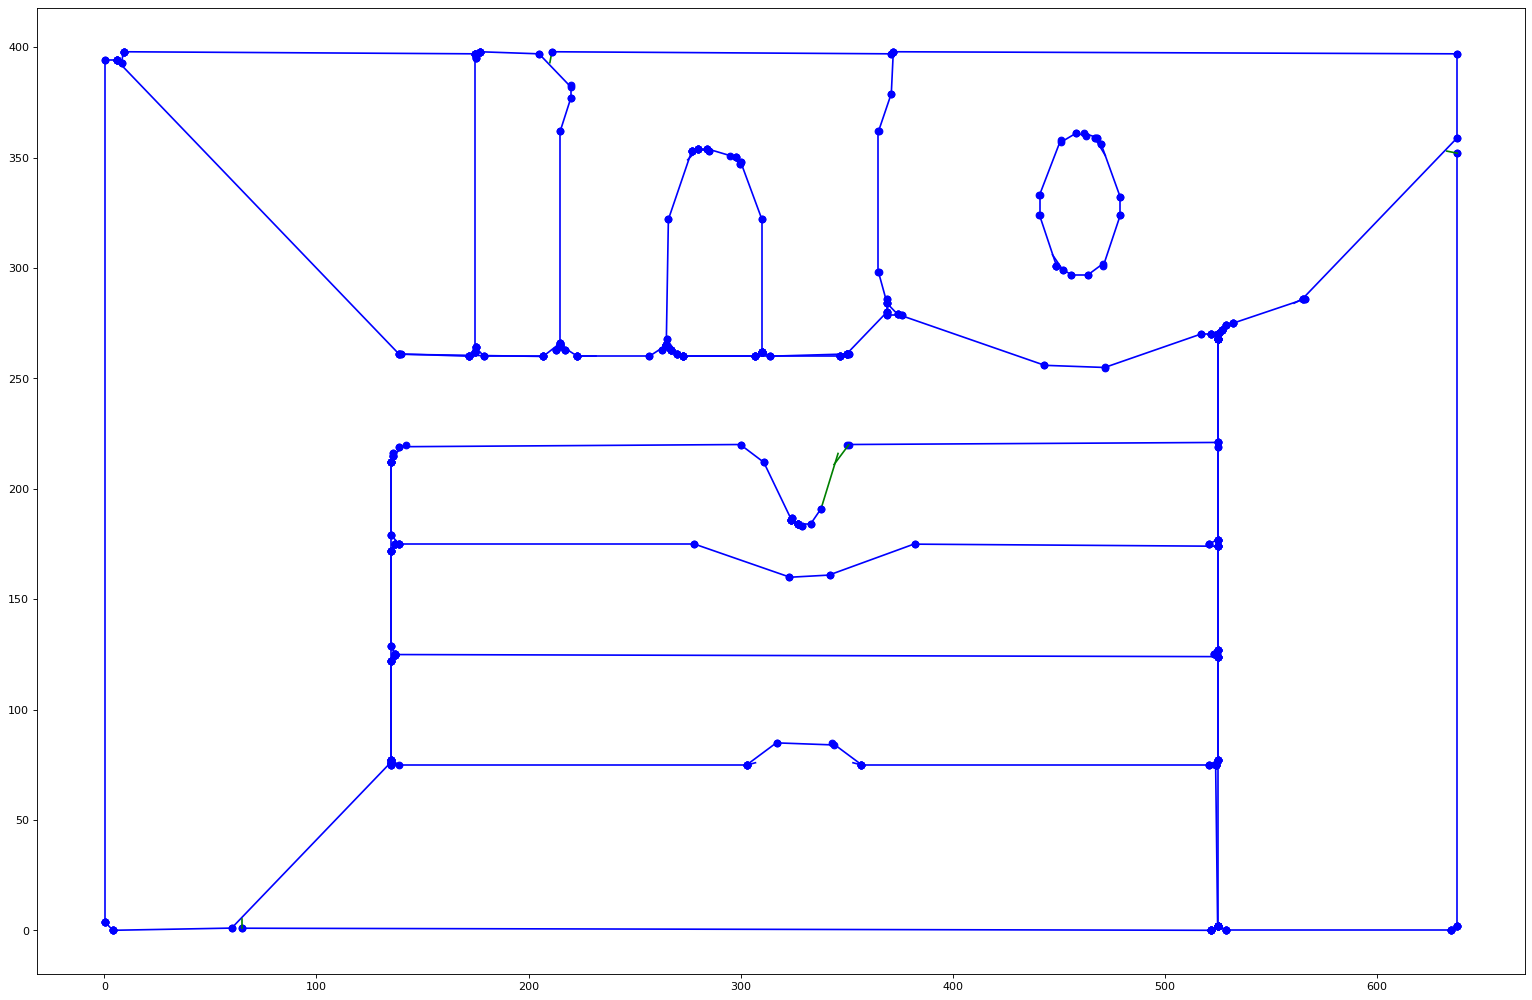

In [13]:
figure(num=None, figsize=(24, 16), dpi=80, facecolor='w', edgecolor='k');            

epsilon = 4

newpoints = []
newlines = []
for i in lines:
    [ax1,ay1,ax2,ay2,ag1,ac1,ll1] = i
    
    
    restline = lines.copy()
    restline.remove(i)
    
    plotit=0
    
    for j in restline:
        [bx1,by1,bx2,by2,bg1,bc1,ll2] = j
        
        if abs(bx1-ax1)<epsilon and abs(by1-ay1)<epsilon:
            plt.plot(ax1,ay1,'bo')
            plotit=plotit+1
            
        if abs(bx1-ax2)<epsilon and abs(by1-ay2)<epsilon:
            plt.plot(ax2,ay2,'bo')
            plotit=plotit+1
            
        if abs(bx2-ax1)<epsilon and abs(by2-ay1)<epsilon:
            plt.plot(ax1,ay1,'bo')
            plotit=plotit+1
            
        if abs(bx2-ax2)<epsilon and abs(by2-ay2)<epsilon:
            plt.plot(ax2,ay2,'bo')
            plotit=plotit+1
            
    newpoints.append([ax1,ay1])
    newpoints.append([ax2,ay2])
    
    if plotit == 0:
        if ll1>5:
            newlines.append([ax1,ay1,ax2,ay2])
            plt.plot((ax1,ax2),(ay1,ay2),'r-')
    elif plotit == 1:
        if ll1>0:
            newlines.append([ax1,ay1,ax2,ay2])
            plt.plot((ax1,ax2),(ay1,ay2),'g-')
    else:
        newlines.append([ax1,ay1,ax2,ay2])
        plt.plot((ax1,ax2),(ay1,ay2),'b-')
    
            
plt.show()

X=np.array(newpoints)

In [14]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler

In [15]:
db = DBSCAN(eps=8, min_samples=1).fit(X)

In [16]:
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)
print('Original Points: %d' % len(newpoints))

Estimated number of clusters: 58
Original Points: 264


In [17]:
#figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k');    
#style = dict(size=10, color='black')

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
centroids = []
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]

    sx=0
    sy=0
    for [x,y] in xy:
        sx=sx+x
        sy=sy+y
        #plt.text(x, y , str(k), **style)
    
    sx=sx/len(xy)
    sy=sy/len(xy)
    centroids.append([sx,sy])
    
    xy = X[class_member_mask & ~core_samples_mask]
    #plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,markeredgecolor='k', markersize=6)
    #plt.plot(sx, sy, 'v', markerfacecolor=col, markeredgecolor='k', markersize=14)

#plt.title('Estimated number of clusters: %d' % n_clusters_)
#plt.show()

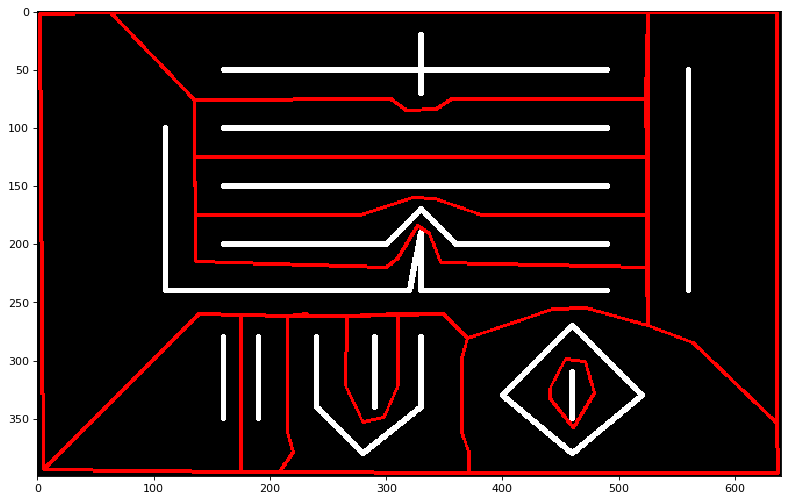

In [18]:
image_data = np.stack((backtorgb[:,:,0],backtorgb[:,:,1],backtorgb[:,:,2]), axis=2)
imagedata_compare = image_data.copy()

for j in newlines: ## redraw lines
    [x1,y1,x2,y2] = j
    
    label1 = [t for (t,[xx,yy]) in enumerate(newpoints) if xx==x1 and yy==y1]  ## get centroid index of point1
    label2 = [t for (t,[xx,yy]) in enumerate(newpoints) if xx==x2 and yy==y2]  ## get centroid index of point2
    
    index1 = labels[label1[0]]
    index2 = labels[label2[0]]
    
    [xx1,yy1]=centroids[index1] ## get coord of centroid 1
    [xx2,yy2]=centroids[index2] ## get coord of centroid 2
    
    imagedata_compare = cv2.line(imagedata_compare, (int(xx1),int(yy1)), (int(xx2),int(yy2)), (255,0,0), 2)
showimage(imagedata_compare)